# Doublet Detection on 8k PBMCs from 10x Genomics

In [1]:
import numpy as np
import doubletdetection
import tarfile
import time
import matplotlib.pyplot as plt

## Download Data from 10x

In [2]:
!curl -O http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
tar = tarfile.open('pbmc8k_filtered_gene_bc_matrices.tar.gz')
tar.extractall()
tar.close()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35.8M  100 35.8M    0     0  6887k      0  0:00:05  0:00:05 --:--:-- 7087k


### Load Count Matrix

In [3]:
matrix_path = 'filtered_gene_bc_matrices/GRCh38/matrix.mtx'
raw_counts = doubletdetection.load_mtx(matrix_path)
# Remove columns with all 0s
zero_genes = (np.sum(raw_counts, axis=0) == 0).A.ravel()
raw_counts = raw_counts[:, ~zero_genes]

## Run Doublet Detection

Right now, PhenoGraph is a bit talkative, so we capture the output to avoid lots of text

In [4]:
%%capture

clf = doubletdetection.BoostClassifier(n_iters=50)
 
start = time.time()
doublets = clf.fit(raw_counts.A).predict(p_thresh=1e-7, voter_thresh=0.8)
end = time.time()

In [5]:
print('Time elapsed: {:.2f} seconds, {:.2f}sec/iteration, for {} iterations'.format(end-start, (end-start) / clf.n_iters, clf.n_iters))

Time elapsed: 774.13 seconds, 15.48sec/iteration, for 50 iterations


## Visualize Results

### Convergence of doublet calls

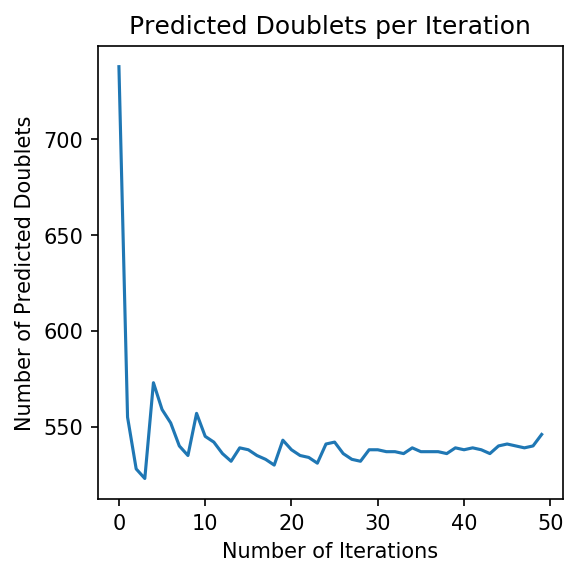

In [6]:
f = doubletdetection.plot.convergence(clf, save='convergence_test.pdf', show=True, p_thresh=1e-7, voter_thresh=0.8)

### Doublets on umap

/usr/local/lib/python3.7/site-packages/doubletdetection/plot.py:117: UserWarning: Sparse raw_counts is automatically densified.
  warnings.warn("Sparse raw_counts is automatically densified.")


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.4429948329925537 seconds
Jaccard graph constructed in 1.3384590148925781 seconds
Wrote graph to binary file in 1.0224361419677734 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.87652
Louvain completed 21 runs in 3.4440650939941406 seconds
PhenoGraph complete in 6.282196044921875 seconds


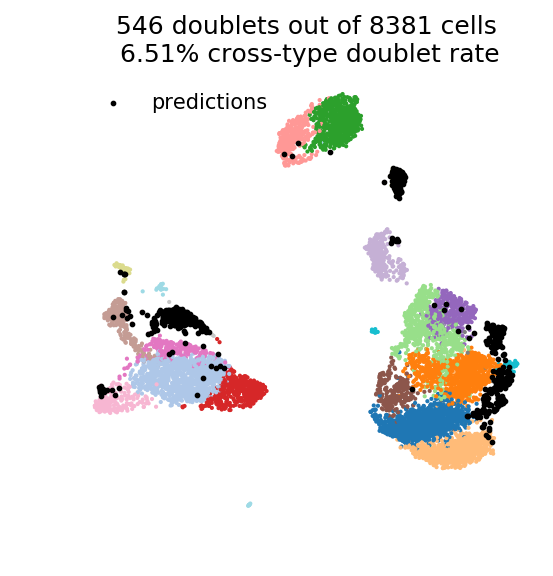

In [7]:
f2, tsne_coords, clusters = doubletdetection.plot.umap_plot(raw_counts, doublets, random_state=1, 
                                                       save='umap_test.pdf', show=True)

### Number of predicted doublets at different threshold combinations

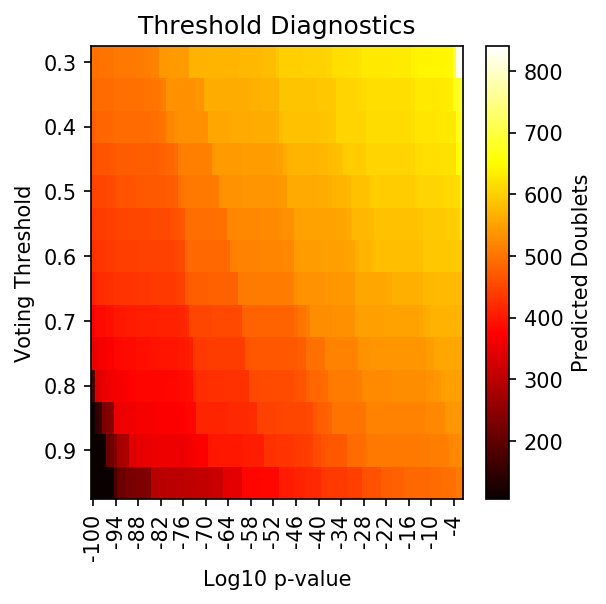

In [8]:
f3 = doubletdetection.plot.threshold(clf, save='threshold_test.pdf', show=True, p_step=6)